In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne

## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [19]:
def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [20]:
def print_graphs(data):
    for i in range(0, 10, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 10, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 10, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [21]:
data = np.load("../../datasets/avi/multi/data_multi.npy")
print(data.shape)

data = data[0]

(8, 10, 8192)


Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

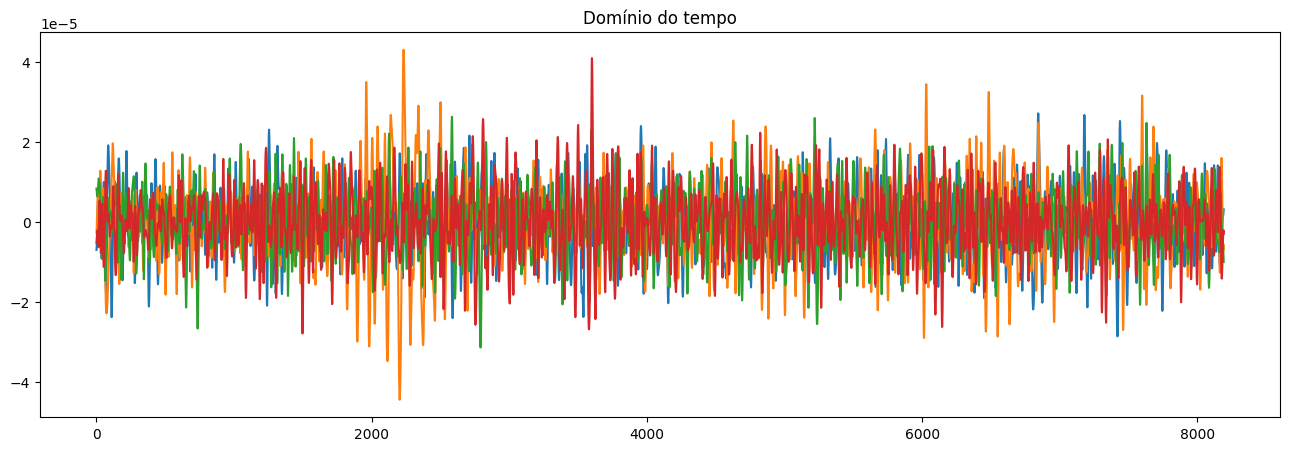

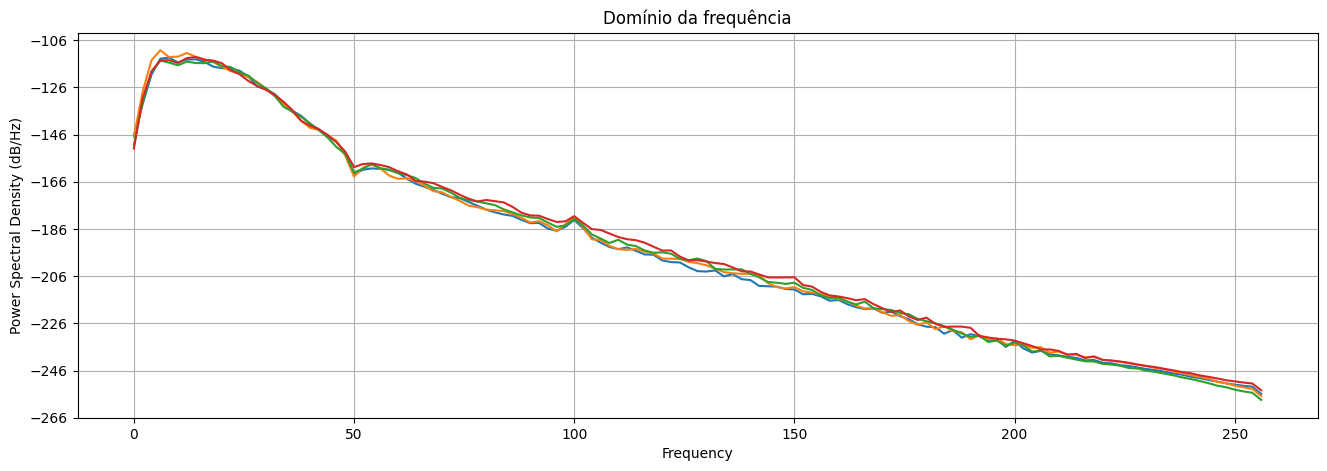

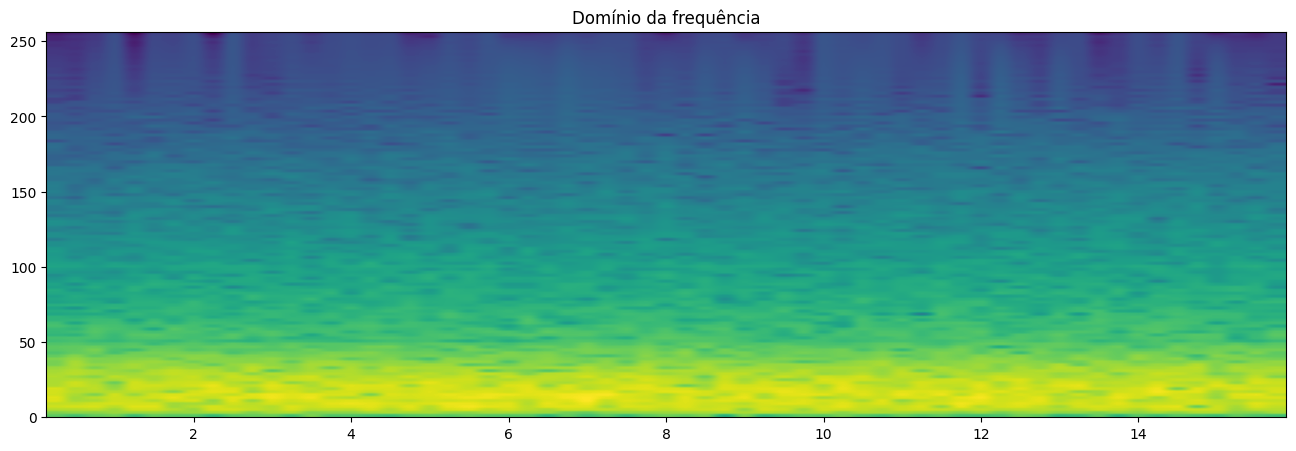

In [22]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [23]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [24]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../../datasets/avi/multi/labels_multi.npy")[0]
unique_labels = sorted(set(labels))
event_dict = {str(value): index  for index, value in enumerate(unique_labels)}
event_dict

{'6.0': 0, '7.0': 1, '7.5': 2, '8.2': 3}

In [25]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(10, dtype=int),
    le.fit_transform(labels))
)

mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


Number of events,10
Events,6.0: 37.0: 17.5: 28.2: 4
Time range,0.000 – 15.998 s
Baseline,off


Need more than one channel to make topography for eeg. Disabling interactivity.



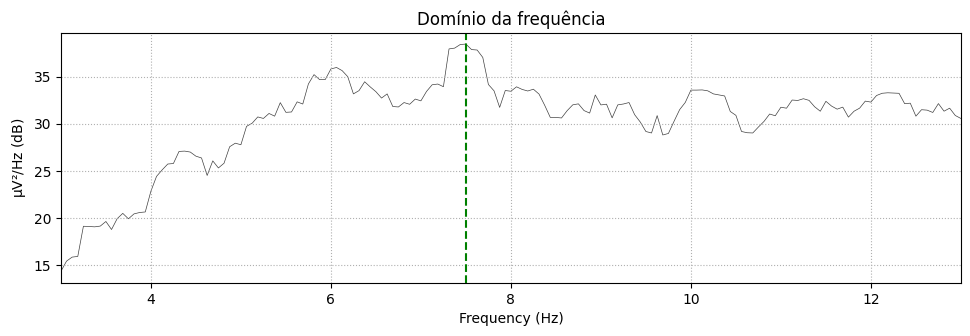

Need more than one channel to make topography for eeg. Disabling interactivity.



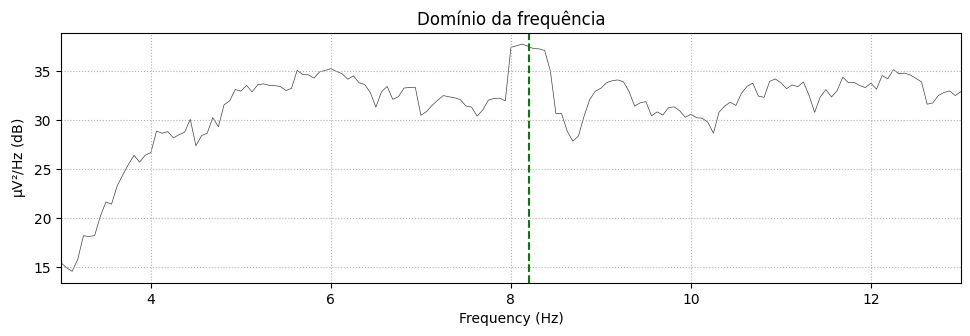

Need more than one channel to make topography for eeg. Disabling interactivity.



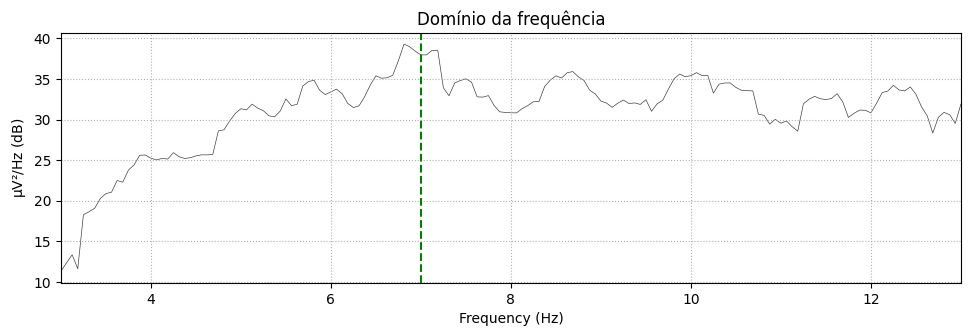

Need more than one channel to make topography for eeg. Disabling interactivity.



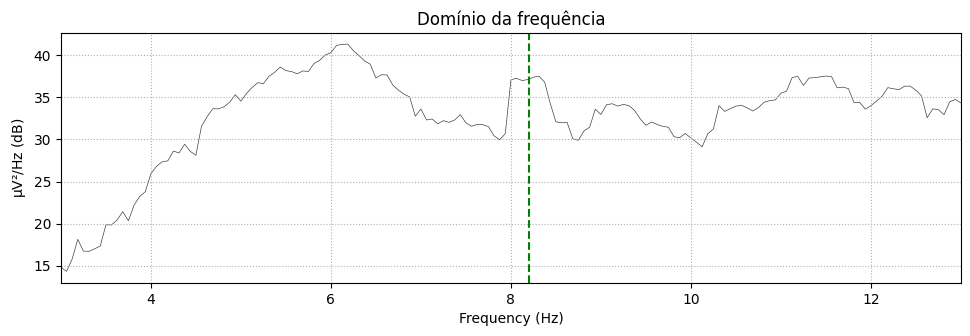

Need more than one channel to make topography for eeg. Disabling interactivity.



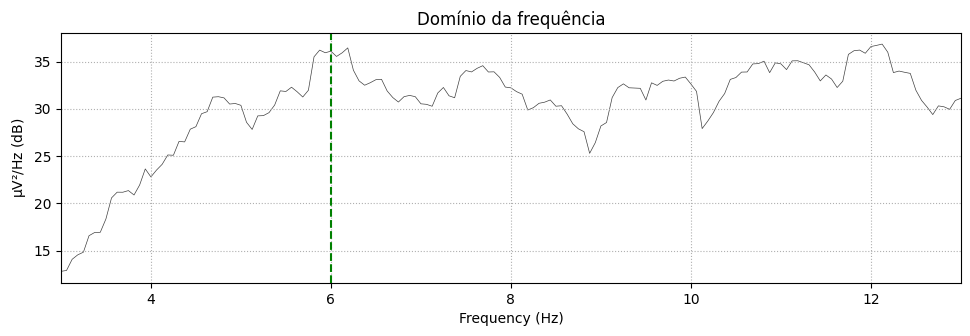

Need more than one channel to make topography for eeg. Disabling interactivity.



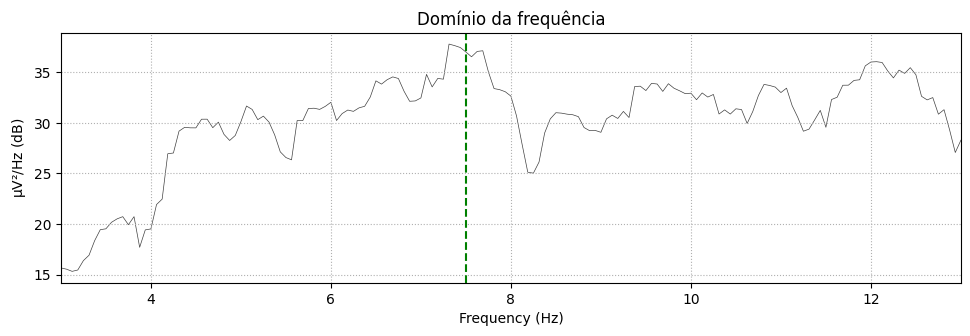

Need more than one channel to make topography for eeg. Disabling interactivity.



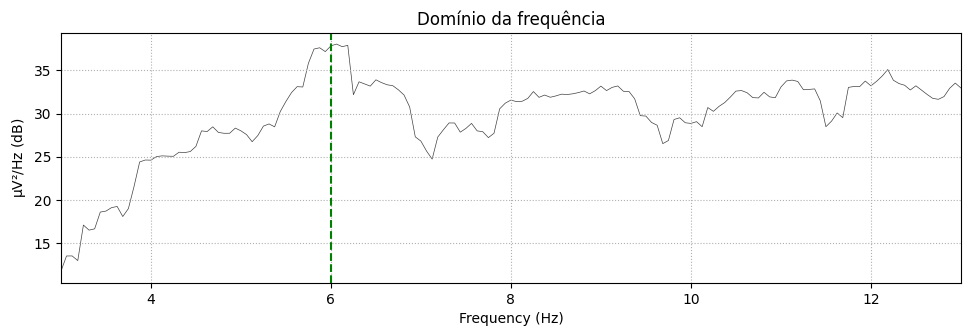

Need more than one channel to make topography for eeg. Disabling interactivity.



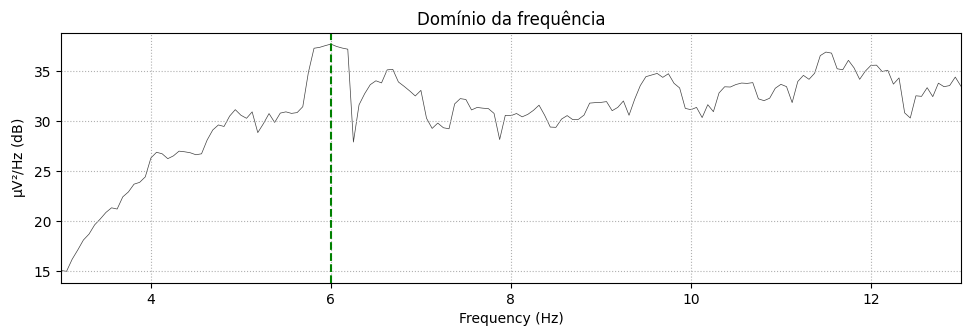

Need more than one channel to make topography for eeg. Disabling interactivity.



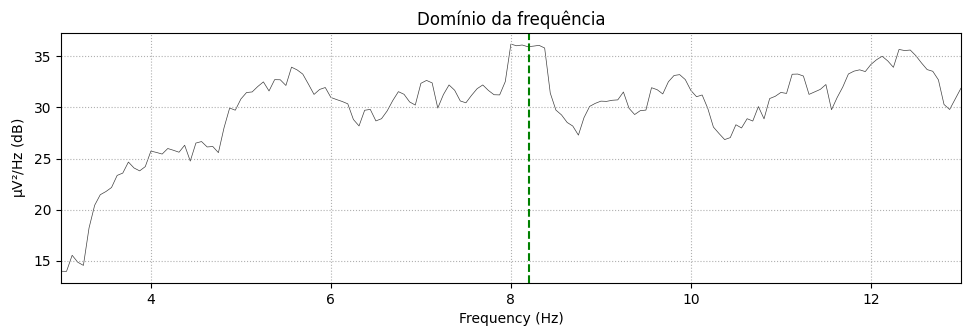

Need more than one channel to make topography for eeg. Disabling interactivity.



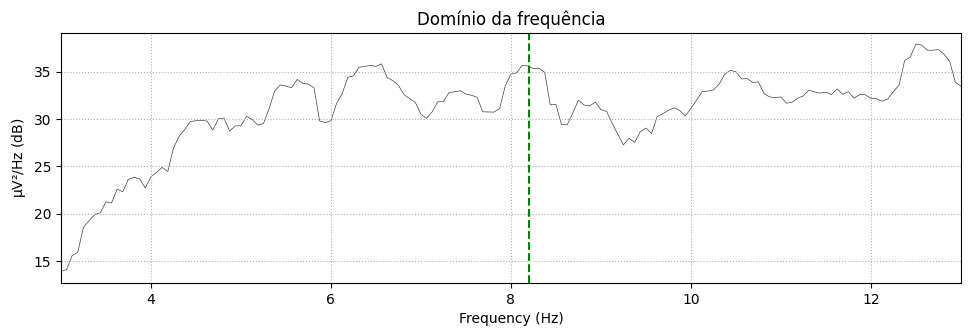

In [26]:

import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()
